In [1]:
# ===============================================
# 0. IMPORTACIÓN DE LIBRERÍAS
# ===============================================
import os
import zipfile
from PIL import Image, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import torch
import torchvision.transforms as T

# ===============================================
# 1. DESCOMPRIMIR DATASET
# ===============================================
zip_path = "/content/archive.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extraído en:", extract_path)

# ===============================================
# 2. SELECCIONAR CLASES A ANALIZAR
# ===============================================

TARGET_CLASSES = ["Natalie Portman", "Scarlett Johansson"]

def find_class_dirs(base_path):
    found = {}
    for root, dirs, files in os.walk(base_path):
        for cls in TARGET_CLASSES:
            if cls.lower().replace(" ", "") in root.lower().replace(" ", ""):
                found[cls] = root
    return found

class_paths = find_class_dirs(extract_path)
class_paths

Dataset extraído en: /content/dataset


{'Natalie Portman': '/content/dataset/Celebrity Faces Dataset/Natalie Portman',
 'Scarlett Johansson': '/content/dataset/Celebrity Faces Dataset/Scarlett Johansson'}

In [2]:
# ===============================================
# 3. EXPLORACIÓN GENERAL
# ===============================================

def explore_dataset(class_paths):
    summary = {}

    for cls, path in class_paths.items():
        image_files = [f for f in os.listdir(path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
        summary[cls] = {
            "count": len(image_files),
            "formats": {},
            "resolutions": [],
            "corrupt": [],
            "empty": []
        }

        for img_name in image_files:
            img_path = os.path.join(path, img_name)
            try:
                img = Image.open(img_path)

                # formato
                fmt = img.format
                summary[cls]["formats"][fmt] = summary[cls]["formats"].get(fmt, 0) + 1

                # resolución
                summary[cls]["resolutions"].append(img.size)

                # detectar imágenes vacías
                if os.path.getsize(img_path) == 0:
                    summary[cls]["empty"].append(img_path)

            except UnidentifiedImageError:
                summary[cls]["corrupt"].append(img_path)

    return summary

summary = explore_dataset(class_paths)
summary

{'Natalie Portman': {'count': 100,
  'formats': {'JPEG': 100},
  'resolutions': [(474, 568),
   (474, 590),
   (474, 486),
   (474, 474),
   (474, 573),
   (474, 576),
   (474, 592),
   (474, 592),
   (474, 548),
   (474, 577),
   (474, 592),
   (474, 582),
   (474, 474),
   (474, 565),
   (474, 592),
   (474, 474),
   (474, 574),
   (474, 590),
   (474, 452),
   (474, 568),
   (474, 589),
   (474, 570),
   (474, 558),
   (474, 474),
   (474, 590),
   (474, 474),
   (474, 568),
   (474, 474),
   (474, 590),
   (474, 569),
   (474, 544),
   (474, 550),
   (160, 135),
   (474, 474),
   (474, 569),
   (474, 498),
   (474, 561),
   (474, 488),
   (474, 591),
   (474, 570),
   (474, 474),
   (160, 188),
   (474, 587),
   (474, 591),
   (474, 588),
   (474, 474),
   (474, 567),
   (474, 587),
   (474, 474),
   (474, 418),
   (474, 435),
   (474, 465),
   (474, 512),
   (474, 592),
   (474, 474),
   (474, 464),
   (474, 592),
   (474, 585),
   (474, 569),
   (474, 543),
   (474, 592),
   (474

In [3]:
for cls, data in summary.items():
    print("\n===================================")
    print("CLASE:", cls)
    print("Total de imágenes:", data["count"])
    print("Formatos:", data["formats"])
    print("Resoluciones distintas:", len(set(data["resolutions"])))
    print("Corruptas:", len(data["corrupt"]))
    print("Vacías:", len(data["empty"]))


CLASE: Natalie Portman
Total de imágenes: 100
Formatos: {'JPEG': 100}
Resoluciones distintas: 51
Corruptas: 0
Vacías: 0

CLASE: Scarlett Johansson
Total de imágenes: 200
Formatos: {'JPEG': 200}
Resoluciones distintas: 50
Corruptas: 0
Vacías: 0


In [4]:
# ===============================================
# 5. ANÁLISIS ESTADÍSTICO RGB
# ===============================================

def compute_rgb_stats(image_paths):
    means = []
    stds = []

    for p in image_paths:
        img = np.array(Image.open(p).convert("RGB")) / 255.0
        means.append(img.mean(axis=(0,1)))
        stds.append(img.std(axis=(0,1)))

    return np.mean(means, axis=0), np.mean(stds, axis=0)

rgb_stats = {}

for cls, path in class_paths.items():
    files = [os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(("jpg","png","jpeg"))]
    mean, std = compute_rgb_stats(files)
    rgb_stats[cls] = {"mean": mean, "std": std}

rgb_stats

{'Natalie Portman': {'mean': array([0.55103909, 0.4538377 , 0.41456872]),
  'std': array([0.27471346, 0.25376911, 0.24450122])},
 'Scarlett Johansson': {'mean': array([0.5505577 , 0.46290075, 0.42576993]),
  'std': array([0.27455731, 0.24566311, 0.23761699])}}

In [5]:
# ===============================================
# 6. DETECCIÓN DE OUTLIERS
# ===============================================

def detect_outliers(path, threshold_dark=0.15, threshold_bright=0.85):
    outliers = {"dark": [], "bright": []}

    for f in os.listdir(path):
        if f.lower().endswith(("jpg","jpeg","png")):
            img = np.array(Image.open(os.path.join(path,f)).convert("RGB")) / 255.0
            brightness = img.mean()
            if brightness < threshold_dark:
                outliers["dark"].append(f)
            if brightness > threshold_bright:
                outliers["bright"].append(f)

    return outliers

outliers = {cls: detect_outliers(path) for cls, path in class_paths.items()}
outliers

{'Natalie Portman': {'dark': [], 'bright': []},
 'Scarlett Johansson': {'dark': [], 'bright': []}}

In [6]:
# ===============================================
# 7. DETECTAR DUPLICADOS
# ===============================================

def image_hash(path, hash_size=16):
    img = Image.open(path).convert("L").resize((hash_size, hash_size))
    pixels = np.array(img).flatten()
    return hashlib.sha1(pixels).hexdigest()

def find_duplicates(path):
    hashes = {}
    duplicates = []

    for f in os.listdir(path):
        if f.lower().endswith(("jpg","jpeg","png")):
            img_path = os.path.join(path, f)
            try:
                h = image_hash(img_path)
                if h in hashes:
                    duplicates.append((img_path, hashes[h]))
                else:
                    hashes[h] = img_path
            except:
                continue

    return duplicates

duplicates = {cls: find_duplicates(path) for cls, path in class_paths.items()}
duplicates

{'Natalie Portman': [],
 'Scarlett Johansson': [('/content/dataset/Celebrity Faces Dataset/Scarlett Johansson/103_c4026864.jpg',
   '/content/dataset/Celebrity Faces Dataset/Scarlett Johansson/003_b416eed5.jpg'),
  ('/content/dataset/Celebrity Faces Dataset/Scarlett Johansson/110_9b23a9ba.jpg',
   '/content/dataset/Celebrity Faces Dataset/Scarlett Johansson/010_4eb6eabe.jpg'),
  ('/content/dataset/Celebrity Faces Dataset/Scarlett Johansson/081_f92d604e.jpg',
   '/content/dataset/Celebrity Faces Dataset/Scarlett Johansson/188_ebfc6465.jpg'),
  ('/content/dataset/Celebrity Faces Dataset/Scarlett Johansson/026_f4a75554.jpg',
   '/content/dataset/Celebrity Faces Dataset/Scarlett Johansson/125_b66015af.jpg'),
  ('/content/dataset/Celebrity Faces Dataset/Scarlett Johansson/163_b87ecc32.jpg',
   '/content/dataset/Celebrity Faces Dataset/Scarlett Johansson/061_bf06c582.jpg'),
  ('/content/dataset/Celebrity Faces Dataset/Scarlett Johansson/073_884e445b.jpg',
   '/content/dataset/Celebrity Faces

In [7]:
# ===============================================
# 8. PREPROCESAMIENTO
# ===============================================

transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],  # valores típicos de ImageNet
        std=[0.229, 0.224, 0.225]
    )
])

In [8]:
# ===============================================
# 9. DATA AUGMENTATION
# ===============================================

augmentation = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor()
])

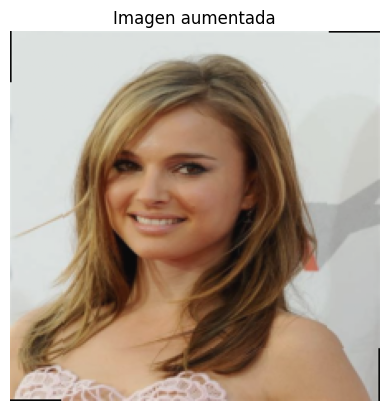

In [9]:
sample_img_path = list(class_paths.values())[0]
sample_img_file = os.listdir(sample_img_path)[0]
img = Image.open(os.path.join(sample_img_path, sample_img_file))

augmented = augmentation(img)

plt.imshow(np.transpose(augmented.numpy(), (1,2,0)))
plt.title("Imagen aumentada")
plt.axis("off")
plt.show()